<a href="https://colab.research.google.com/github/naimakhan33/-Post-Pruning/blob/main/Flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flowers-recognition.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
count = 0
dirs = os.listdir('flowers/')

for dir in dirs:
    files = os.listdir(os.path.join('flowers', dir))
    print(dir + ' folder has ' + str(len(files)) + ' flowers')
    count += len(files)

print('flowers folder has ' + str(count) + ' flowers')


tulip folder has 984 flowers
rose folder has 784 flowers
daisy folder has 764 flowers
dandelion folder has 1052 flowers
sunflower folder has 733 flowers
flowers folder has 4317 flowers


In [ ]:
base_dir = 'flowers/'
img_size = 180
batch = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch,
    image_size=(img_size, img_size)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch,
    image_size=(img_size, img_size)
)



Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt


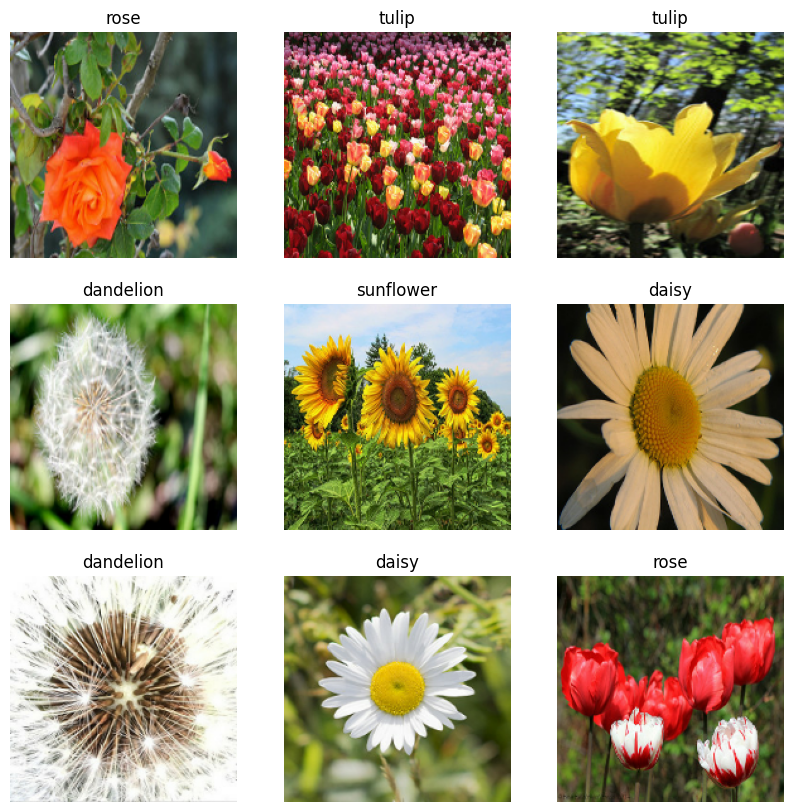

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flower_names[labels[i]])
        plt.axis("off")

In [ ]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


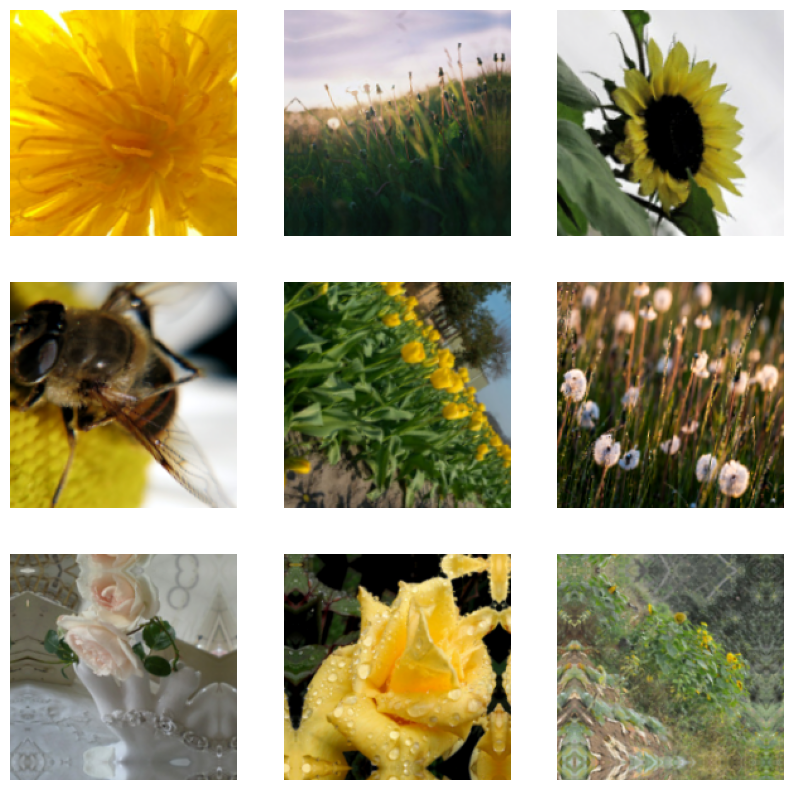

In [ ]:
i = 0
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.cast(augmented_image[0], tf.uint8))
        plt.axis("off")


In [ ]:
model = Sequential([
    data_augmentation,  # your data augmentation pipeline
    layers.Rescaling(1./255),  # normalize pixel values to [0,1]

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 flower classes
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics=['accuracy'] )


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop])

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8006 - loss: 0.5240 - val_accuracy: 0.7532 - val_loss: 0.6812
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8087 - loss: 0.5090 - val_accuracy: 0.7636 - val_loss: 0.6386
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7967 - loss: 0.5245 - val_accuracy: 0.7543 - val_loss: 0.6564
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8008 - loss: 0.5229 - val_accuracy: 0.7659 - val_loss: 0.6518
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8069 - loss: 0.5097 - val_accuracy: 0.7671 - val_loss: 0.6491
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8059 - loss: 0.4941 - val_accuracy: 0.7323 - val_loss: 0.7626
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7978 - loss: 0.5244 - val_accuracy: 0.7775 - val_loss: 0.6776
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8121 - loss: 0.4938 - 

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp = np.expand_dims(input_image_array, axis=0) / 255.0

    # Predict
    predictions = model.predict(input_image_exp)
    predicted_class = np.argmax(predictions[0])
    print("Predicted class name:", flower_names[predicted_class])


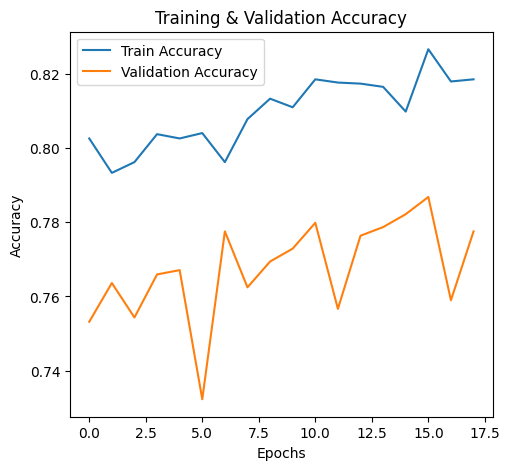

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

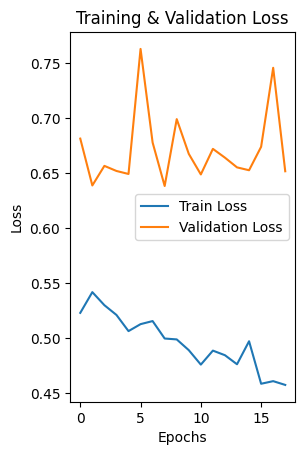

In [ ]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save("flower_classifier_model.keras")